In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os
import cv2


from keras.preprocessing.image import ImageDataGenerator, DirectoryIterator
from keras.utils import to_categorical
from keras.applications.inception_v3 import InceptionV3
from vit_keras import vit
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from sklearn.model_selection import StratifiedKFold, train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

C:\Users\User\anaconda3\envs\GPU3\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [5]:
classes = ['no', 'yes']
img_size = 224


#Create the Inception network
base_incep = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

x = base_incep.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(classes), activation='softmax')(x)

inception = Model(inputs=base_incep.input, outputs=predictions)

for layer in base_incep.layers:
    layer.trainable = False

inception.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])



#Create the Resnet network
base_resn = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
x = base_resn.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(classes), activation='softmax')(x)

resnet = Model(inputs=base_resn.input, outputs=predictions)

for layer in base_resn.layers:
    layer.trainable = False

resnet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])


#Create the VITB16 network
b16 = vit.vit_b16(image_size=(img_size, img_size), activation='sigmoid', include_top=True, pretrained_top=False, classes=2)

b16.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

In [3]:
data_path = r'C:\Users\User\Desktop\Master_Y1\Deep_learning\BrainTumorDetection-main\brain_tumor_dataset'
classes = ['no', 'yes']
img_size = 224

# Load and preprocess the data
X = []
Y = []
for c in classes:
    path = os.path.join(data_path, c)
    class_num = classes.index(c)
    for img in os.listdir(path):
        img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
        img_arr = cv2.resize(img_arr, (img_size, img_size))
        X.append(img_arr)
        Y.append(class_num)

X = np.array(X)
Y = np.array(Y)
Y = to_categorical(Y, num_classes=len(classes))

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
# Train the model and save the history
reshistory = resnet.fit(X_train, Y_train, batch_size=32, epochs=10, validation_data=(X_val, Y_val))

In [ ]:
# Train the model and save the history
incephistory = inception.fit(X_train, Y_train, batch_size=32, epochs=10, validation_data=(X_val, Y_val))

In [6]:
# Train the model and save the history
b16history = b16.fit(x=X_train, y=Y_train, batch_size=8, epochs=10, validation_data=(X_val, Y_val))

Epoch 1/10
26/26 [==============================] - 28s 468ms/step - loss: 1.2984 - binary_accuracy: 0.5025 - val_loss: 0.7763 - val_binary_accuracy: 0.6078
Epoch 2/10
26/26 [==============================] - 9s 349ms/step - loss: 0.7030 - binary_accuracy: 0.6040 - val_loss: 0.7167 - val_binary_accuracy: 0.4412
Epoch 3/10
26/26 [==============================] - 9s 352ms/step - loss: 0.6555 - binary_accuracy: 0.6262 - val_loss: 0.6424 - val_binary_accuracy: 0.6471
Epoch 4/10
26/26 [==============================] - 9s 347ms/step - loss: 0.6119 - binary_accuracy: 0.6733 - val_loss: 0.5879 - val_binary_accuracy: 0.6961
Epoch 5/10
26/26 [==============================] - 9s 357ms/step - loss: 0.5586 - binary_accuracy: 0.7228 - val_loss: 0.4823 - val_binary_accuracy: 0.7549
Epoch 6/10
26/26 [==============================] - 9s 350ms/step - loss: 0.4843 - binary_accuracy: 0.7995 - val_loss: 0.4534 - val_binary_accuracy: 0.8137
Epoch 7/10
26/26 [==============================] - 9s 346ms/st

In [7]:
def evaluate_model(model, history):

    # Print the loss function
    print("Loss function:", history.history['loss'])

    # Plot the training and validation loss
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.show()

    # Print the training and validation accuracy
    train_acc = history.history['binary_accuracy']
    val_acc = history.history['val_binary_accuracy']
    print("Training Accuracy:", train_acc)
    print("Validation Accuracy:", val_acc)

    # Plot the training and validation accuracy
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend()
    plt.show()

    # Calculate the confusion matrix for the validation set
    Y_pred = model.predict(X_val)
    Y_pred_classes = np.argmax(Y_pred, axis=1)
    Y_val_classes = np.argmax(Y_val, axis=1)
    cm = confusion_matrix(Y_val_classes, Y_pred_classes)
    print("Confusion Matrix:")
    print(cm)

    # Plot the confusion matrix
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
    plt.show()

    # Create a table showing the training and validation loss and accuracy
    results_df = pd.DataFrame({'Loss': history.history['loss'], 'Accuracy': history.history['binary_accuracy'],
                               'Val_Loss': history.history['val_loss'], 'Val_Accuracy': history.history['val_binary_accuracy']})
    print(results_df)

    # Get the indices and confidence scores of the misclassified images
    misclassified_indices = np.where(Y_pred_classes != Y_val_classes)[0]
    misclassified_confidence = np.max(Y_pred[misclassified_indices], axis=1)

    # Plot the misclassified images with confidence scores
    plt.figure(figsize=(20, 20))
    for i, index in enumerate(misclassified_indices[:25]):
        plt.subplot(5, 5, i+1)
        plt.imshow(X_val[index])
        plt.axis('off')
        plt.title('Predicted: %s\nActual: %s\nConfidence: %.2f' % (Y_pred_classes[index], Y_val_classes[index], misclassified_confidence[i]))

    plt.show()

Loss function: [1.2983735799789429, 0.7030318379402161, 0.6555207371711731, 0.6118612885475159, 0.5585918426513672, 0.48430779576301575, 0.4619036316871643, 0.45226964354515076, 0.47304072976112366, 0.3991626799106598]


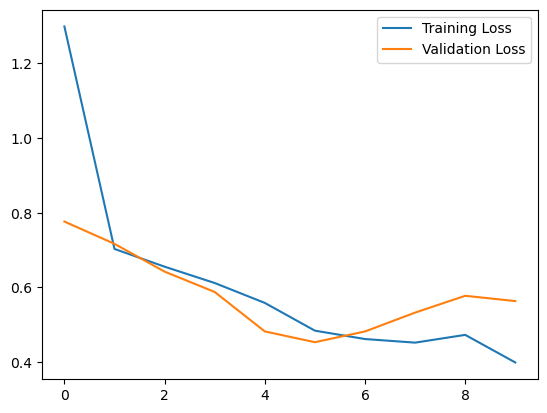

Training Accuracy: [0.5024752616882324, 0.603960394859314, 0.6262376308441162, 0.6732673048973083, 0.7227723002433777, 0.7995049357414246, 0.7896039485931396, 0.8168317079544067, 0.7549505233764648, 0.844059407711029]
Validation Accuracy: [0.6078431606292725, 0.44117647409439087, 0.6470588445663452, 0.6960784196853638, 0.7549019455909729, 0.813725471496582, 0.8039215803146362, 0.8039215803146362, 0.6666666865348816, 0.7156862616539001]


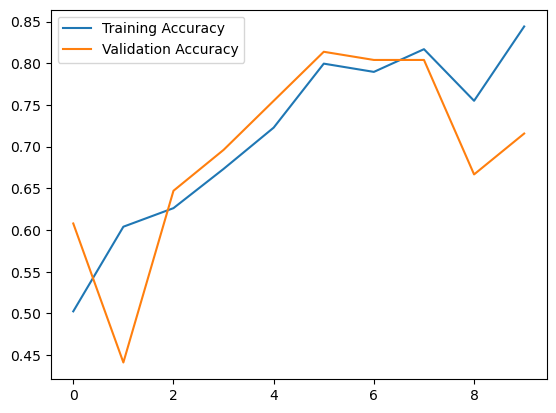

2/2 [==============================] - 4s 272ms/step
Confusion Matrix:
[[17  3]
 [11 20]]


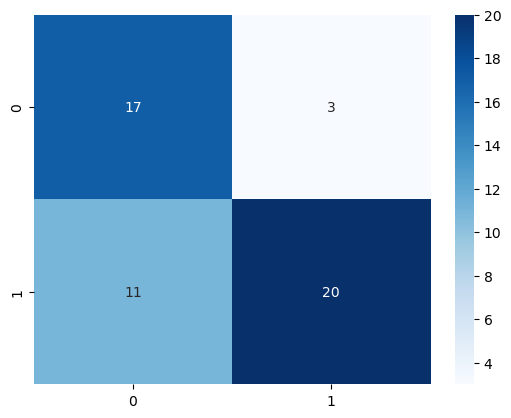

       Loss  Accuracy  Val_Loss  Val_Accuracy
0  1.298374  0.502475  0.776301      0.607843
1  0.703032  0.603960  0.716670      0.441176
2  0.655521  0.626238  0.642355      0.647059
3  0.611861  0.673267  0.587867      0.696078
4  0.558592  0.722772  0.482304      0.754902
5  0.484308  0.799505  0.453448      0.813725
6  0.461904  0.789604  0.482201      0.803922
7  0.452270  0.816832  0.532619      0.803922
8  0.473041  0.754951  0.577633      0.666667
9  0.399163  0.844059  0.563528      0.715686


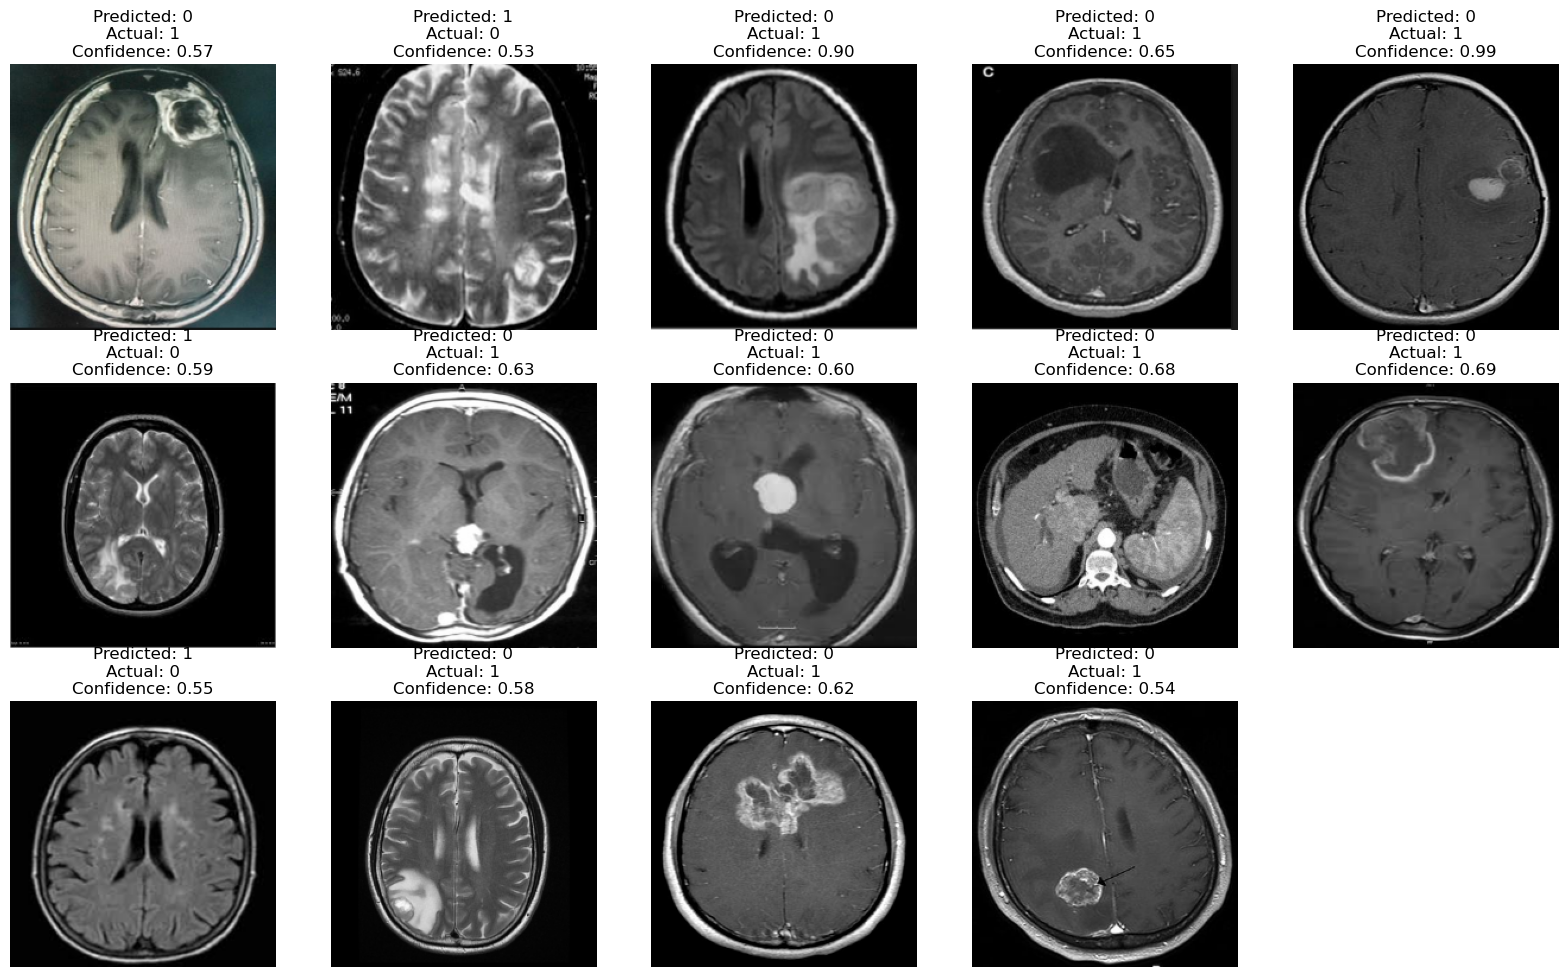

NameError: name 'reshistory' is not defined

In [9]:
evaluate_model(b16, b16history)
evaluate_model(resnet, reshistory)
evaluate_model(inception, incephistory)